In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Define column names
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load datasets
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Calculate RUL for train data
rul = train.groupby('unit_nr')['time_cycles'].max().reset_index()
rul.columns = ['unit_nr', 'max_cycles']
train = train.merge(rul, on='unit_nr', how='left')
train['RUL'] = train['max_cycles'] - train['time_cycles']
train.drop('max_cycles', axis=1, inplace=True)

# Scale the data
scaler = MinMaxScaler()
feature_columns = setting_names + sensor_names
train[feature_columns] = scaler.fit_transform(train[feature_columns])
test[feature_columns] = scaler.transform(test[feature_columns])


In [ ]:
rul_scaler = MinMaxScaler()
train['RUL'] = rul_scaler.fit_transform(train[['RUL']])

In [ ]:
# Function to create sliding windows
def create_sliding_windows(df, sequence_length=30):
    sequences = []
    targets = []
    for unit in df['unit_nr'].unique():
        unit_data = df[df['unit_nr'] == unit]
        for i in range(len(unit_data) - sequence_length):
            sequence = unit_data.iloc[i:i + sequence_length][feature_columns].values
            target = unit_data.iloc[i + sequence_length]['RUL']
            sequences.append(sequence)
            targets.append(target)
    return np.array(sequences), np.array(targets)

# Generate train sequences
sequence_length = 30
X_train, y_train = create_sliding_windows(train, sequence_length)

# Prepare test data: Use the last `30` rows for each unit in the test dataset
X_test = []
for unit in test['unit_nr'].unique():
    unit_data = test[test['unit_nr'] == unit].tail(sequence_length)
    X_test.append(unit_data[feature_columns].values)
X_test = np.array(X_test)  # Shape: (Number of units, 30, 24)


In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(sequence_length, len(feature_columns)), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Predict RUL
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


C:\Users\Soham\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0294 - mae: 0.1233 - val_loss: 0.0169 - val_mae: 0.0932
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0100 - mae: 0.0714 - val_loss: 0.0183 - val_mae: 0.0928
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090 - mae: 0.0661 - val_loss: 0.0226 - val_mae: 0.1002
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0086 - mae: 0.0645 - val_loss: 0.0155 - val_mae: 0.0849
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0081 - mae: 0.0620 - val_loss: 0.0158 - val_mae: 0.0855
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0071 - mae: 0.0583 - val_loss: 0.0161 - val_mae: 0.0827
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0071 - mae: 0.0574 - val_loss: 0.0148 - val_mae: 0.0824
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0071 - mae: 0.0586 - val_loss: 0.0130 - val_mae: 0.0761
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

In [ ]:
# Predict RUL for test dataset
scaled_rul_pred = model.predict(X_test)

# Inverse scale the predictions (if RUL was scaled during training)
rul_pred = rul_scaler.inverse_transform(scaled_rul_pred)

# Evaluate predictions
rul_actual = y_test.values.flatten()
print("Predicted RUL:", rul_pred.flatten())
print("Actual RUL:", rul_actual)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted RUL: [135.58861   143.40996    56.217903   81.61074   112.30357   117.591446
 116.73976    94.81247   136.96162    88.94818    75.01734   103.69154
  78.39595   125.01271   112.108345   98.69313    54.453106   33.706287
 111.815216   22.192434   81.06103   138.35031   149.50154    27.233654
 126.1797    172.92229    94.51136   109.17791   108.7115    105.71808
  16.43609    49.014877  136.23763     9.805944   17.163483   30.75466
  18.756067   49.253105  130.84315    38.606594   21.651464    9.5474415
  62.348976  126.32985    91.86536    47.667107  122.23023   115.17327
  25.15431   115.70124   113.177925   33.95981    35.519886  128.7776
 222.83438    19.96792   114.00837    48.35513   124.56048   126.74824
  31.462568   48.91132    93.431114   33.837044  201.56363    26.14708
 236.98756    16.754454  135.5588     88.95323   135.38354    61.571503
 100.380196  124.14917   113.50669    15.620398   36.807606  171.2479
 111.741264  103.868

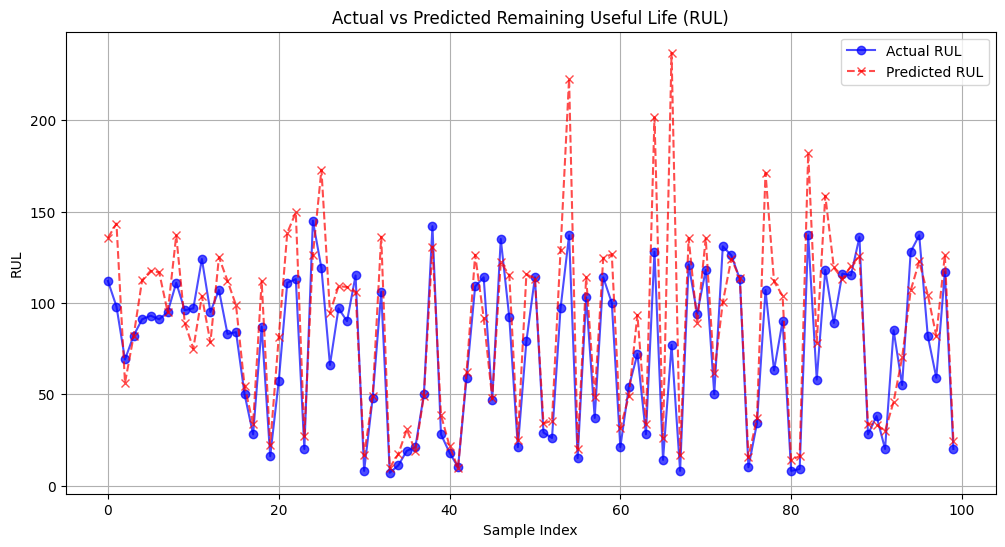

In [ ]:
import matplotlib.pyplot as plt

# Example data (Replace these with actual rul_pred and rul_actual from your code)
#rul_pred = rul_pred.flatten()
#rul_actual = rul_actual

# Plot Predicted vs Actual RUL
plt.figure(figsize=(12, 6))
plt.plot(rul_actual, label="Actual RUL", color="blue", marker='o', linestyle='-', alpha=0.7)
plt.plot(rul_pred, label="Predicted RUL", color="red", marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Remaining Useful Life (RUL)")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()
